In [87]:
import pandas as pd
import requests
import folium
import matplotlib.pyplot as plt
import math
import numpy as np

In [88]:
#liste des gares API SNCF
url_gares = "https://ressources.data.sncf.com/api/v2/catalog/datasets/liste-des-gares/exports/json?limit=-1&offset=0&timezone=UTC"
gares = requests.get(url_gares)
wb_gares = gares.json()

df_gares = pd.DataFrame(wb_gares)
df_gares.head(2)

,code_uic,libelle,fret,voyageurs,code_ligne,rg_troncon,pk,commune,departemen,idreseau,idgaia,x_l93,y_l93,x_wgs84,y_wgs84,c_geo,geo_point_2d,geo_shape
0,87755223,Bandol,N,O,930000,1,050+607,BANDOL,VAR,3077,29a5a626-dfbc-11e3-a2ff-01a464e0362d,923833.7169,6.230702e+06,5.749816,43.140491,"{'lon': 5.749815526229215, 'lat': 43.140491048...","{'lon': 5.749815526229215, 'lat': 43.140491047...","{'type': 'Feature', 'geometry': {'coordinates'..."
1,87696179,Pouilly-sur-Loire,O,O,750000,1,214+004,POUILLY-SUR-LOIRE,NIEVRE,6141,297a4c76-dfbc-11e3-a2ff-01a464e0362d,697358.2537,6.686913e+06,2.965051,47.282528,"{'lon': 2.965051211539136, 'lat': 47.282528482...","{'lon': 2.965051211539134, 'lat': 47.282528481...","{'type': 'Feature', 'geometry': {'coordinates'..."


In [89]:
#frequentation des gares API SNCF
url_freq_gares = "https://ressources.data.sncf.com/api/v2/catalog/datasets/frequentation-gares/exports/json?limit=-1&offset=0&timezone=UTC"
freq_gares = requests.get(url_freq_gares)
wb_freq_gares = freq_gares.json()

df_freq_gares = pd.DataFrame(wb_freq_gares)
df_freq_gares.head(2)

,nom_gare,code_uic_complet,code_postal,segmentation_drg,total_voyageurs_2021,total_voyageurs_non_voyageurs_2021,total_voyageurs_2020,total_voyageurs_non_voyageurs_2020,total_voyageurs_2019,total_voyageurs_non_voyageurs_2019,total_voyageurs_2018,total_voyageurs_non_voyageurs_2018,totalvoyageurs2017,total_voyageurs_non_voyageurs_2017,total_voyageurs_2016,total_voyageurs_non_voyageurs_2016,total_voyageurs_2015,total_voyageurs_non_voyageurs_2015
0,Abbaretz,87481614,44170,c,27466,27466,22773,22773,38473,38473,38027,38027,35637,35637,33021,33021,35989,35989
1,Agay,87757559,83530,c,25094,25094,15390,15390,22284,22284,15093,15093,14154,14154,19240,19240,19121,19121


In [90]:
df_freq_gares.rename(columns = {'code_uic_complet':'code_uic'}, inplace = True)

In [91]:
#nous avons plus de données sur les gares que sur la frequentation
print(len(df_gares))
print(len(df_freq_gares))

3819
2970


In [92]:
#on regarde quelles gares de la liste des gares ne sont pas dans la database qui contient les frequentations
outer_merged = pd.merge(df_gares, df_freq_gares, how="outer", on=["code_uic"])
outer_merged[outer_merged['nom_gare'].isna()==True][['code_uic', 'libelle']]
#ce sont de petites gares donc on va considérer seulement celles de la database des frequentations

,code_uic,libelle
3,87784488,Cases-de-Pène
12,87396671,La Chartre-sur-le-Loir
35,87271320,La Courneuve-Dugny
39,87172411,Margut-Fromy
49,87172593,Vouziers
...,...,...
3785,87286807,Genech
3793,87755835,La Motte-Ste-Rosseline
3799,87729210,Port-Fluvial-de-Chalon-sur-Saône
3801,87286252,Rougebarre


In [93]:
#on fusionne donc les dataframes à partir de df_freq_gares
left_merged = pd.merge(df_freq_gares, df_gares, how="left", on=["code_uic"])
df_gares_merged = left_merged[['code_uic','total_voyageurs_non_voyageurs_2020', 'nom_gare', 'x_wgs84','y_wgs84']]

(array([3.271e+03, 1.100e+01, 1.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 5.000e+00]),
 array([1.00000000e+00, 1.52624522e+07, 3.05249034e+07, 4.57873546e+07,
        6.10498058e+07, 7.63122570e+07, 9.15747082e+07, 1.06837159e+08,
        1.22099611e+08, 1.37362062e+08, 1.52624513e+08]),
 <BarContainer object of 10 artists>)

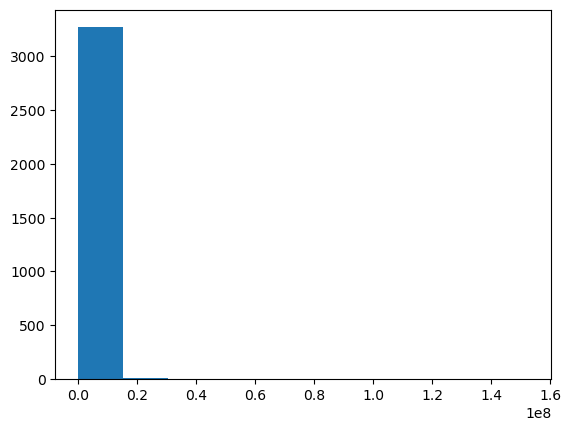

In [94]:
#gérer les cas 0 et NaN --> pour 0, on les enlève (gares désafectées) mais il faudra gérer le cas NaN qui contient notamment la gare Paris Est

df_gares_merged = df_gares_merged.drop(df_gares_merged[df_gares_merged['total_voyageurs_non_voyageurs_2020']==0].index)
plt.hist(df_gares_merged['total_voyageurs_non_voyageurs_2020'])

(array([ 16.,  32.,  92., 259., 639., 944., 774., 403., 121.,  11.]),
 array([ 0.        ,  1.88434913,  3.76869826,  5.65304739,  7.53739652,
         9.42174565, 11.30609478, 13.19044391, 15.07479304, 16.95914217,
        18.8434913 ]),
 <BarContainer object of 10 artists>)

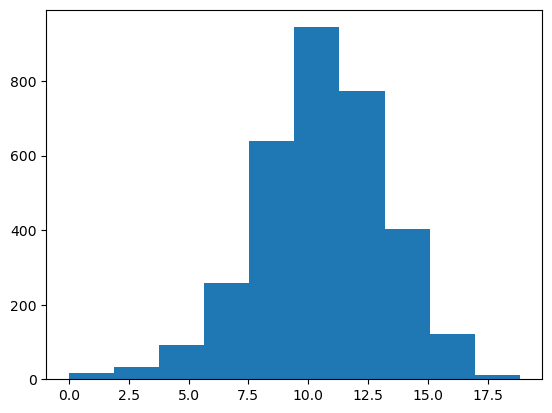

In [95]:
#pour mieux visualiser les frequentations, on passe au log
df_gares_merged['log_total_voyageurs_non_voyageurs_2020'] = np.log(df_gares_merged['total_voyageurs_non_voyageurs_2020'])
plt.hist(df_gares_merged['log_total_voyageurs_non_voyageurs_2020'])


In [96]:
#filtre sur les frequentations : on ne garde que les gares les plus frequentees
df_gares_principales = df_gares_merged[df_gares_merged['log_total_voyageurs_non_voyageurs_2020']>= 14]

#on regarde ensuite les gares pour lesquelles il nous manque les coordonnees gps
df_gares_principales[df_gares_principales['x_wgs84'].isna()==True]


,code_uic,total_voyageurs_non_voyageurs_2020,nom_gare,x_wgs84,y_wgs84,log_total_voyageurs_non_voyageurs_2020
382,87758607,7980634,Châtelet les Halles,NaN,NaN,15.892528
637,87756403,4085871,Monaco-Monte-Carlo,NaN,NaN,15.223045
975,87113209,3862190,Pantin,NaN,NaN,15.166745
979,87758904,107666015,Paris Gare du Nord,NaN,NaN,18.494545
1069,87654798,2865667,Rosa Parks,NaN,NaN,14.868312
1074,87113696,3206275,Rosny Bois Perrier,NaN,NaN,14.980620
1163,87113795,3664906,Villiers-sur-Marne - Le Plessis-Trévise,NaN,NaN,15.114313
1293,87116046,2496908,Émerainville - Pontault-Combault,NaN,NaN,14.730564
1810,87113704,2380920,Rosny-sous-Bois,NaN,NaN,14.682998
2325,87113522,1562549,Le Chénay Gagny,NaN,NaN,14.261829


In [97]:
#on sort les donnees manquantes du dataframe, on va maintenant les chercher grace a d'autres sources de donnees
df_gares_principales = df_gares_principales.dropna()

In [98]:
#liste des gares API SNCF
url_gares = "https://data.iledefrance.fr/api/v2/catalog/datasets/gares-et-stations-du-reseau-ferre-dile-de-france-par-ligne/exports/json?limit=-1&offset=0&timezone=UTC"

gares = requests.get(url_gares)
wb_gares = gares.json()

df_gares = pd.DataFrame(wb_gares)
df_gares

,geo_point_2d,geo_shape,gares_id,nom_long,nom,nom_sous,nom_sur,id_ref_lda,nom_lda,id_ref_zdl,...,ligne,indice_lig,res_com,exploitant,idf,principal,x,y,picto,nom_iv
0,"{'lon': 2.077731764565598, 'lat': 48.970665047...","{'type': 'Feature', 'geometry': {'coordinates'...",6.0,Achères-Ville,Achères-Ville,None,None,73604.0,Achères Ville,46647.0,...,RER A,A,RER A,SNCF,1.0,0.0,632479.4115,6.874919e+06,"{'thumbnail': True, 'filename': 'RER_A.svg', '...",Achères-Ville
1,"{'lon': 2.077731764565598, 'lat': 48.970665047...","{'type': 'Feature', 'geometry': {'coordinates'...",7.0,Achères-Ville,Achères-Ville,None,None,73604.0,Achères Ville,46647.0,...,TRAIN L,L,TRAIN L,SNCF,1.0,0.0,632479.4115,6.874919e+06,"{'thumbnail': True, 'filename': 'train_L.svg',...",Achères-Ville
2,"{'lon': 2.4036331049084922, 'lat': 48.71262898...","{'type': 'Feature', 'geometry': {'coordinates'...",31.0,Athis-Mons,Athis-Mons,None,None,63134.0,Athis-Mons,46395.0,...,RER C,C,RER C,SNCF,1.0,0.0,656121.8463,6.845998e+06,"{'thumbnail': True, 'filename': 'RER_C.svg', '...",Athis-Mons
3,"{'lon': 2.329927170608276, 'lat': 48.872157493...","{'type': 'Feature', 'geometry': {'coordinates'...",32.0,Auber,Auber,None,None,478926.0,Auber,45873.0,...,RER A,A,RER A,RATP,1.0,0.0,650849.5187,6.863779e+06,"{'thumbnail': True, 'filename': 'RER_A.svg', '...",Auber
4,"{'lon': 2.9057369645485345, 'lat': 48.85955731...","{'type': 'Feature', 'geometry': {'coordinates'...",222.0,Crécy-la-Chapelle,Crécy-la-Chapelle,None,None,68293.0,Crécy-la-Chapelle,47894.0,...,TRAIN P,P,TRAIN P,SNCF,1.0,1.0,693083.9625,6.862173e+06,"{'thumbnail': True, 'filename': 'train_P.svg',...",Crécy-la-Chapelle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,"{'lon': 2.4086200551769896, 'lat': 48.87209702...","{'type': 'Feature', 'geometry': {'coordinates'...",1093.0,Adrienne Bolland,Adrienne Bolland,None,None,73669.0,Adrienne Bolland,58502.0,...,TRAM 3b,3B,TRAM 3b,RATP,1.0,0.0,656621.5514,6.863726e+06,"{'thumbnail': True, 'filename': 'tram_T3b.svg'...",Adrienne Bolland
1178,"{'lon': 2.3188044013442384, 'lat': 48.89630846...","{'type': 'Feature', 'geometry': {'coordinates'...",1213.0,Honoré de Balzac,Honoré de Balzac,None,None,424926.0,Honoré De Balzac,45482.0,...,TRAM 3b,3B,TRAM 3b,RATP,1.0,0.0,650056.8404,6.866471e+06,"{'thumbnail': True, 'filename': 'tram_T3b.svg'...",Honoré de Balzac
1179,"{'lon': 2.3019910195900777, 'lat': 48.95582939...","{'type': 'Feature', 'geometry': {'coordinates'...",1194.0,Épinay-sur-Seine,Épinay-sur-Seine,None,None,72383.0,Épinay-sur-Seine,462330.0,...,TRAM 8,8,TRAM 8,RATP,1.0,0.0,648882.6751,6.873101e+06,"{'thumbnail': True, 'filename': 'tram_T8.svg',...",Épinay-sur-Seine
1180,"{'lon': 2.0744435747033823, 'lat': 48.83705261...","{'type': 'Feature', 'geometry': {'coordinates'...",1255.0,Bailly,Bailly,None,None,480951.0,Bailly,480933.0,...,TRAM 13,13,TRAM 13,TRANSKEO,1.0,0.0,632064.5395,6.860065e+06,None,Bailly


In [99]:
#on recupere les donnees manquantes (sauf monaco, mais pas vrmt en France) grace à l'API de la region idf
url_region_idf = "https://data.iledefrance.fr/api/v2/catalog/datasets/gares-et-stations-du-reseau-ferre-dile-de-france-par-ligne/exports/json?limit=-1&offset=0&timezone=UTC"

region_idf = requests.get(url_region_idf)
wb_region_idf = region_idf.json()

df_region_idf = pd.DataFrame(wb_region_idf)

#on repere les gares dont on souhaite retrouver les coordonnees gps
gares_manquantes = ["Châtelet-Les Halles", "Pantin", "Gare du Nord", "Rosa Parks", "Rosny-Bois-Perrier", "Villiers-sur-Marne - Le Plessis-Trévise", "Émerainville-Pontault-Combault", "Rosny-sous-Bois", "Le Chénay-Gagny", "Roissy-en-Brie", "Les Boullereaux-Champigny", "Nogent-le-Perreux", "Gare de l'Est", "Val de Fontenay"]

df_region_idf = df_region_idf[df_region_idf.nom.isin(gares_manquantes)==True]
#suppression des doublons (lorsque différents trains passent à une même gare en idf)
df_region_idf.drop_duplicates(subset ="nom", keep = 'first', inplace=True)

df_region_idf.reset_index(inplace = True)
df_region_idf = df_region_idf.drop(['index'], axis=1)


In [100]:
#recuperation des donnees gps pour la nouvelle base de donnees
longitude = [0]*len(df_region_idf)
latitude = [0]*len(df_region_idf)

for i in range(len(df_region_idf)):
    longitude[i] = df_region_idf['geo_point_2d'][i]['lon']
    latitude[i] = df_region_idf['geo_point_2d'][i]['lat']

df_region_idf['y_wgs84']=latitude
df_region_idf['x_wgs84']=longitude


In [101]:
m = folium.Map(location=[45.8666, 2.3333], min_zoom=3, max_zoom=14, zoom_start=5.3, tiles = 'Stamen Terrain')
#affichage des gares principales dont on avait les donnees gps par l'API SNCF
for i in df_gares_principales.index:
    tooltip = df_gares_principales['nom_gare'][i]
    folium.Marker([df_gares_principales['y_wgs84'][i],df_gares_principales['x_wgs84'][i]], popup=df_gares_principales['nom_gare'][i], tooltip=tooltip).add_to(m)

#affichage des gares principales dont les donnees viennent de l'API region IDF
for i in df_region_idf.index:
    tooltip = df_region_idf['nom'][i]
    folium.Marker([df_region_idf['y_wgs84'][i],df_region_idf['x_wgs84'][i]], popup=df_region_idf['nom'][i], tooltip=tooltip).add_to(m)

m